{0} # 3rd Down Analysis: Weeks {1}-{2}

This is an automated IPython Notebook that displays 3rd Down Performance over the selected weeks, with analysis highlighted around the team of your choice.  To see the code used to build the graphics, simply select the click on them.  Thanks!

In [1]:
#requests handles our interaction with the websites.
import requests
import re
from bs4 import BeautifulSoup
#Import necessary Python Packages
import nflgame
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
from PIL import Image
from pylab import *
import urllib, cStringIO
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, \
     AnnotationBbox

#......A bunch of things to make the graphs below nice.............................

#Display Graphs
%matplotlib inline

#Set canvas for Graphs
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})


#This is a function I use to put percentages on the y-axis of graphs below (Stackoverflow)
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)

#Declare I am writing a function called getTextfromUrl that receives a url as input.
def getTeamlogo(team):

    url="http://www.nfl.com/teams"
#The program will attempt all actions indented under "try", and if it fails will execute the commands indented beneath except.
    try:
        #if http is not in the url, append that to the url
        if 'http' not in url.lower():
            url='http://'+ url

        #Use the requests library to reach out the url and return a RESPONSE object which contains page source code, cookies, and
        #other miscellaneous information from the page, error if the url does not respond in 5 seconds.
        page = requests.get(url, timeout=5)

        #take the source code of the url and from the page RESPONSE object (by accessing .text) and create a BeautifulSoup
        #object to make the source code easier to manipulate.
        soup = BeautifulSoup(page.text)

        #Assign the remaining text values to a variable called text
        allLogos= [link.get("src") for link in soup.find_all(src=re.compile("/logos/teams"))]
        return [k for k in allLogos if team in k][0]

    
    #If any of the above code fails, assign an empty string "" to the variable called text     
    except:
        return None
    
def teamlabel():
    file1 = cStringIO.StringIO(urllib.urlopen(getTeamlogo(label.lower())).read())
    img = Image.open(file1)
    imagebox = OffsetImage(img, zoom=.35)
    ab = AnnotationBbox(imagebox, xy=(x, y),pad=0)
    plt.gca().add_artist(ab)
    
def eaglabel():
    file1 = cStringIO.StringIO(urllib.urlopen(getTeamlogo(label.lower())).read())
    img = Image.open(file1)
    imagebox = OffsetImage(img, zoom=.35)
    ab = AnnotationBbox(imagebox, xy=(x, y), bboxprops = dict(fc = 'green'))
    plt.gca().add_artist(ab)
    
print "Click here for initializaliton code. (Graphics and Import Statements)"

In [3]:
#Grab all plays from games in Week {0}-{1}, 2015
games = nflgame.games(2015, week=list(arange({0},{2})))
plays = nflgame.combine_plays(games)

#Build a Dataset with all 3rd down plays out of the set of plays built above
columns=["team", "ytg", "success", "rush", "patt", "playdescription"]

df = pandas.DataFrame(columns=columns)

for p in plays.filter(down=3):
    tempdf = pandas.DataFrame([[p.team, p.yards_togo, p.first_down, p.rushing_att, 
                                p.passing_att,p]],columns=columns)
    df = df.append(tempdf, ignore_index=True)

#Remove No Plays and FGs 
df=df[~df["playdescription"].astype("str").str.contains("No Play")]
df=df[~df["playdescription"].astype("str").str.contains("field goal")]

#Set few odd plays where success ==2 to 1, to indicate a successful 3rd down conversion.
df.set_value(df[df['success']==2].index, 'success', 1)

print "Click Here to see the actual NFL Data Import Code."

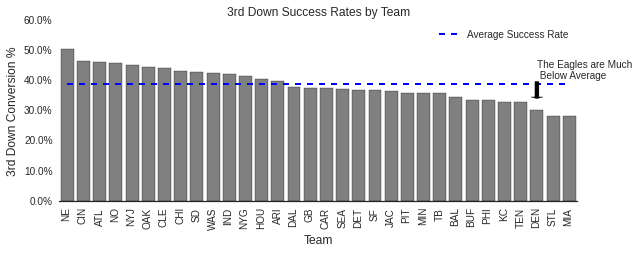

In [6]:
#Build table that shows 3rd down rate by team
third=df.pivot_table(index='team', values='success', aggfunc=[np.sum, len,np.mean])
third.columns=["Conversions", "Attempts", "Conv_Rate"]
third.sort("Conv_Rate", ascending=False, inplace=True)


#............Plot the third down rate by team....................
plt.figure()

g = sns.factorplot(x=third.index, y="Conv_Rate", data=third, aspect=2, kind='bar',
                  color="gray")
g.set_xticklabels(rotation=90)

sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3rd Down Conversion %", fontsize=12)
plt.gca().set_xlabel("Team", fontsize=12)

plt.plot(np.ones(32)*df["success"].mean(),lw=2, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("3rd Down Success Rates by Team")
plt.annotate("Here is how {0} is doing", 
             xy=(third.rank(ascending=False)[third.index=='{0}']["Conv_Rate"]-1,
                 third[third.index=='{0}']["Conv_Rate"]), 
             xytext=(third.rank(ascending=False)[third.index=='{0}']["Conv_Rate"]-1,
                     third["Conv_Rate"].mean()+.02),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()

plt.show()

The poor performance is certainly related to yards to go on third downs, as Warren Sharp did point out that the Eagles also have the 3rd highest yards to go average in the league, but it does not look like that tells the whole story.  

The graph below shows the league wide 3rd down conversion rate by yards to go, and then I overlaid team performance to show how teams are performing compared to how you'd expect based on average yards to go.  I've highlighted the Eagles with a Green label, and you can see that the the Eagles are performing below where they'd expect with their ~8 average yards to go.  

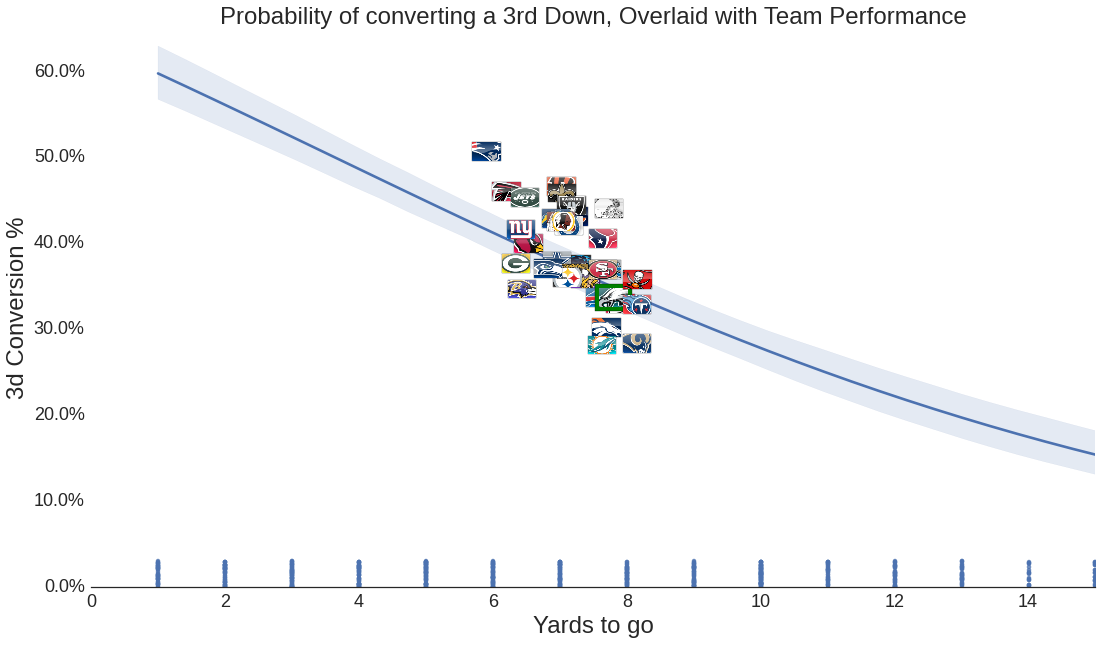

In [7]:
#Build a Series with avg ytg for each team
avgdist=df.pivot_table(index='team', values='ytg', aggfunc=np.mean)
avgdist=avgdist.sort_index()
avgdist.name="avgdist"

third=third.sort_index()


sns.set_context({"figure.figsize": (18, 10)})
plt.figure()

sns.regplot(x="ytg", y="success",data=df,logistic=True, y_jitter=.03, truncate=True )
plt.scatter(x=avgdist, y=third["Conv_Rate"], color="red")
plt.xlim(0,15)
plt.ylim(0,.65)

sns.despine(left=True)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title("Probability of converting a 3rd Down, Overlaid with Team Performance", 
          fontsize=24)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3d Conversion %", fontsize=24)
plt.gca().set_xlabel("Yards to go", fontsize=24)

for label, x, y in zip(avgdist.index, 
                       avgdist, 
                       third["Conv_Rate"]):
    if label=="PHI":
        eaglabel()
    
    else:
        teamlabel()
    
    

There are 2 reasons (besides the inheret luck involved) that a team's third down performance would deviate from the expectation when looking at their average yards to go. 

1.  The team is simply better (or worse) than the rest of the league at converting third downs when controlling for distance.

2.  The team's average yards to go is skewed by some out of the ordinary third and longs, so their expected 3rd down conversion rate is lower than it would be if we looked more granularly at the distance they face on third downs.  

For instance, a team with an average yards to of 7 yards to go could have an expected conversion rate of 38% (.38 * 3 / 3) if all of their conversions are from 7 yards out, or they could have an expected conversion rate of more than 40% if two out of of every three third downs has one yard remaining, and the third is 3rd and 20 ((.6 + .6 + .1) / 3).  

Since the Eagles are outside of the light blue band, their poor performance has to do with additional factors besides luck.

Below I break down each team's third downs by distance, and see if the Eagle's below expected performance has to do with the breakdown of distances they've had to go, or if they are actually performing worse on third down than we would expect. 

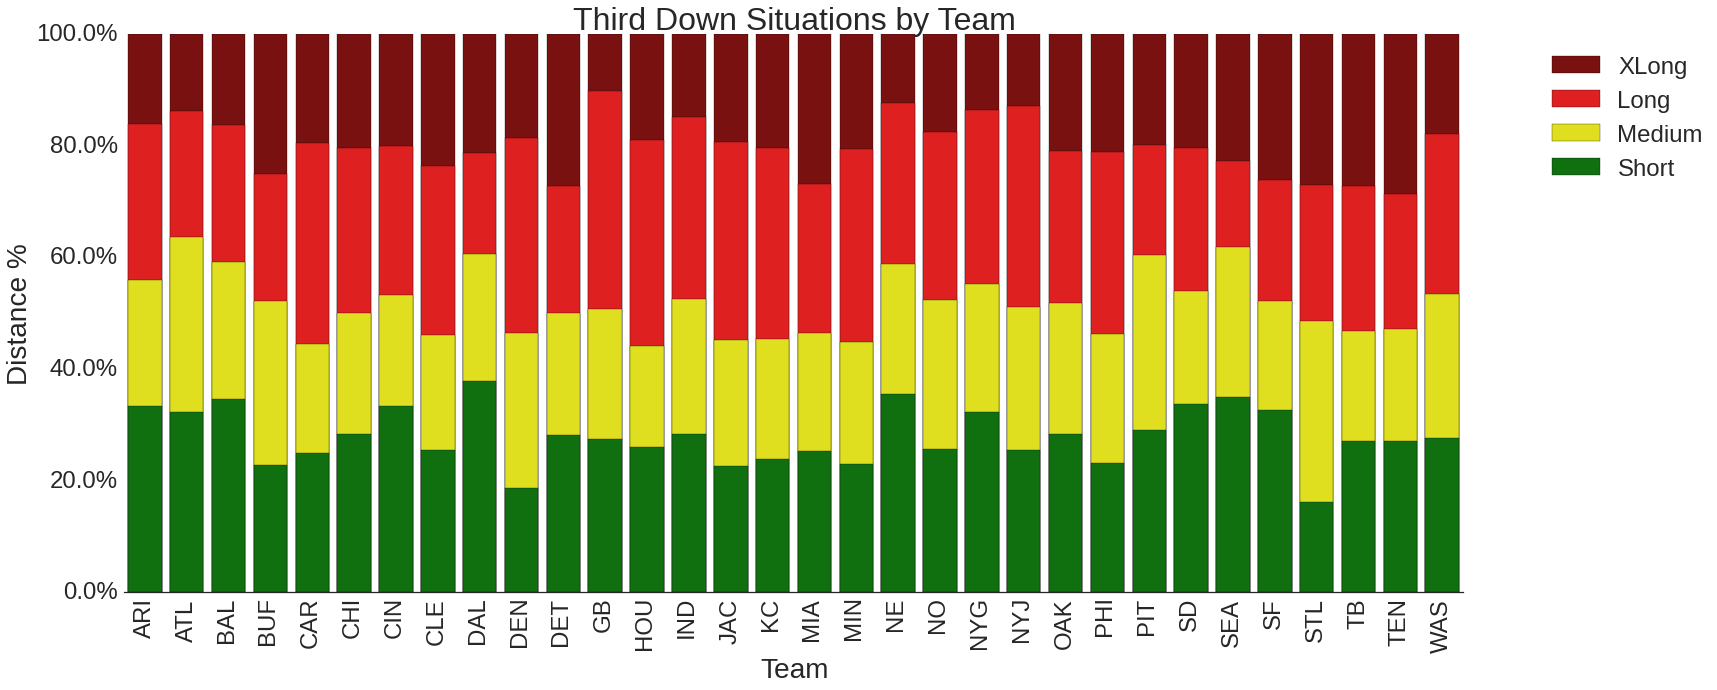

In [8]:
labels=['short','mid','long','long+']

#Build distance buckets for 3rd down distance
df['ytgBuckets']=pandas.cut(df.ytg, [0,3,6,10,50], right=True, labels=labels,retbins=False,
                            precision=3, include_lowest=False).astype("str")

distfreq=df.pivot_table(index='team', columns='ytgBuckets', values='success', aggfunc=len)
distfreq=distfreq[labels]
distfreq=distfreq.divide(distfreq.sum(axis=1), axis='rows')

sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = distfreq.index , y = distfreq.sum(axis=1), color = "darkred", label="XLong")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-1]].sum(axis=1), 
            color = "red", label="Long")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-2]].sum(axis=1), 
            color = "yellow", label="Medium")
bottom_plot=sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-3]].sum(axis=1), 
            color = "green", label="Short")
sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Third Down Situations by Team", fontsize=32)
bottom_plot.set_ylabel("Distance %", fontsize=28)
bottom_plot.set_xlabel("Team", fontsize=28)
plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':24})

#bottom_plot.set_xticklabels(rotation=90)


Looking at the data graphically, there does not appear to be anything skewed about the Eagles 3rd down situations (where we'd see more short and extra long attempts). Let's calculate a new expected third down percentage for each team given the breakdown of their opportunities and see how each team fares through this lens.

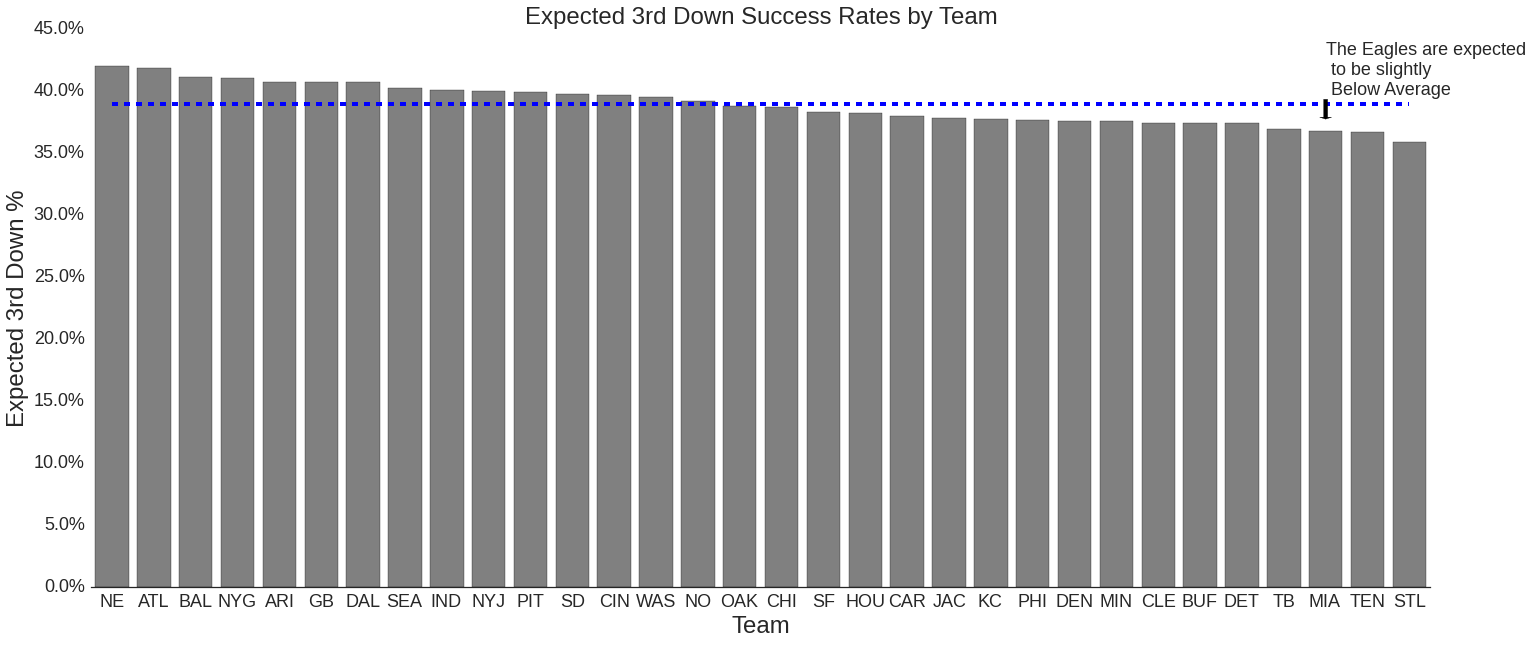

In [9]:
#Table that shows third down attempts and rate by team and distance
#thirdytg=df.pivot_table(index='team', columns='ytgBuckets', values='success', aggfunc=[len,  np.mean])

#NFL 3rd down rates by distance
lenmeans=df.pivot_table(columns='ytgBuckets', values='success', aggfunc=np.mean)
e3d=distfreq.multiply(
    lenmeans, axis=1).sum(axis=1)

e3d.name="e3d"
try:
    third=third.join(e3d)

except:
    pass

third['expsuccess']=third['Attempts'] * third['e3d']
third.sort('e3d', inplace=True, ascending=False)
plt.plot(np.ones(32)*df["success"].mean(),lw=4, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("Expected 3rd Down Success Rates by Team", fontsize=24)
plt.annotate("The Eagles are expected\n to be slightly\n Below Average", 
             xy=(29,third[third.index=="PHI"]["e3d"]), 
             xytext=(29,third["Conv_Rate"].mean()+.01),
             arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=18)

sns.despine(left=True)
sns.barplot(x = third.index , y = third.e3d, color="gray")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("Expected 3rd Down %", fontsize=24)
plt.gca().set_xlabel("Team", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

It's pretty clear that the Eagles are indeed putting themselves in a poor position, as their expected 3rd down rate still ranks in the bottom 4 in the league.  However, there is a large discrepancy between their expected 3rd down rate and their actual.  The graph below looks at each team's expected # of 3rd downs, when controlled for situation, versus their actual number of third downs. 

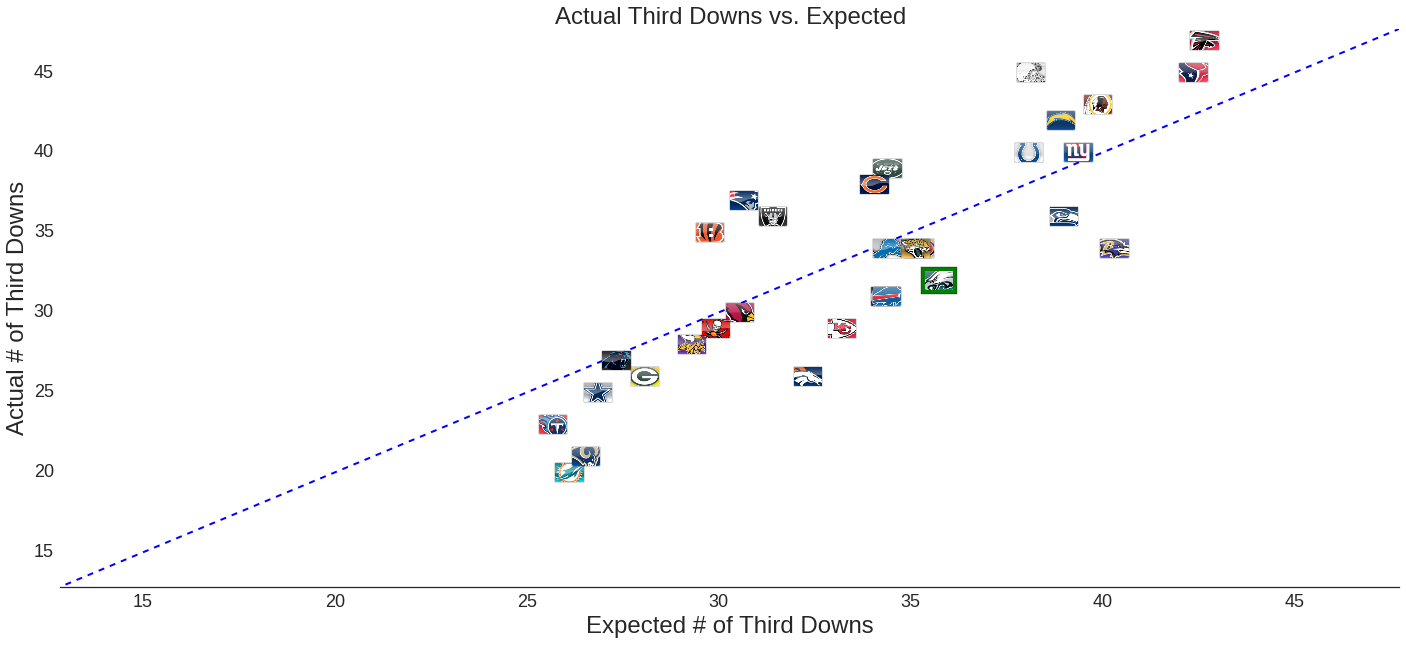

In [18]:
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

g=plt.scatter(x=third.expsuccess, y=third.Conversions, s=200, c="red")

plt.plot(np.arange(0,70,1),lw=2, color="blue",linestyle="--", label="Average Success Rate")

plt.axis([third.expsuccess.min()/2,third.expsuccess.max()+5,\
          third.expsuccess.min()/2,third.expsuccess.max()+5])
plt.title("Actual Third Downs vs. Expected", fontsize=24)
plt.xlabel("Expected # of Third Downs", fontsize=24)
plt.ylabel("Actual # of Third Downs", fontsize=24)
sns.despine(left=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for label, x, y in zip(third.index, 
                       third["expsuccess"], 
                       third["Conversions"]):
    if label=="PHI":
        eaglabel()
    
    else:
        teamlabel()


You can see that the Eagles are one of the teams most below their expectation.  This means that not only are the Eagles putting themselves in poor positions, they are also not doing well for the positions they're in.  In fact, the Eagles are third in the league in missed third downs.  It looks like Chip Kelly, Sam Bradford and the rest of the Eagles have a lot of work ahead of them to succeed.  Let's dive a little deeper into the Eagles performance and see where they have the biggest opportunity for improvement.

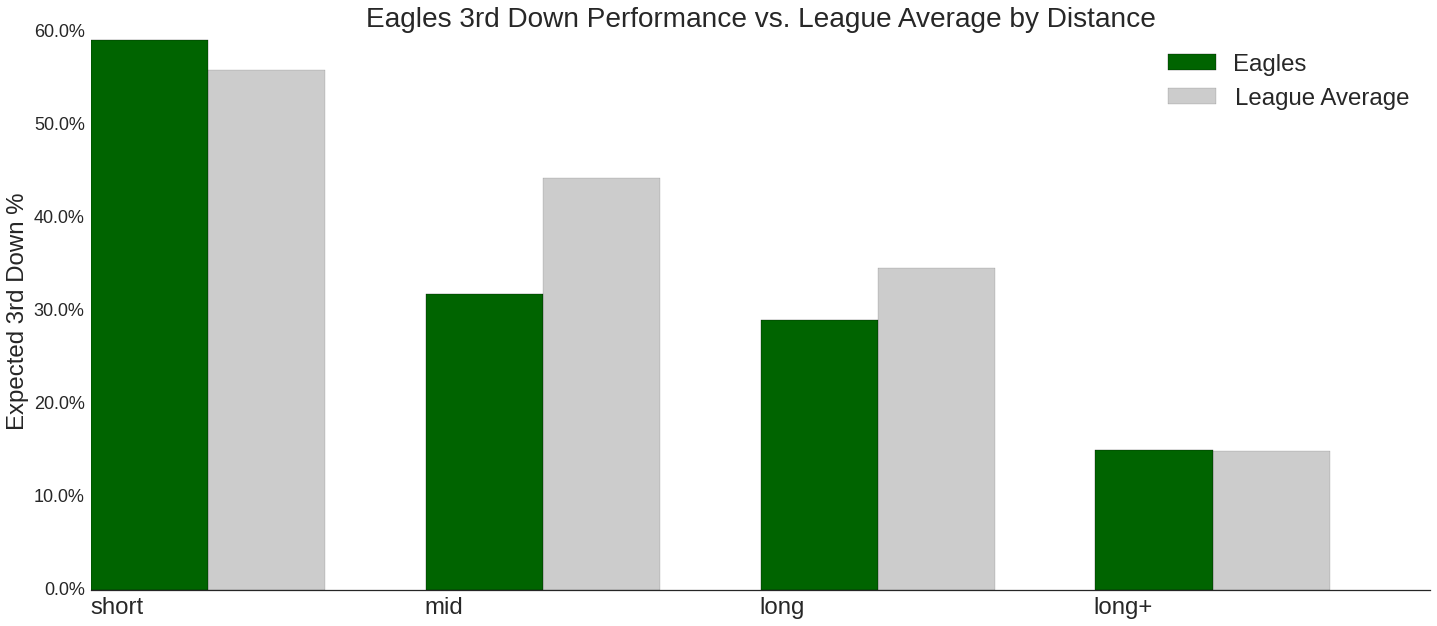

In [11]:
lenmeans=df.pivot_table(columns='ytgBuckets', values='success', aggfunc=np.mean)[labels]
eagmeans=df[df["team"]=="PHI"].pivot_table(columns='ytgBuckets', 
                                           values='success', aggfunc=np.mean)[labels]

bar_width = 0.35

opacity = 0.4
index = np.arange(4)


rects1 = plt.bar(index, eagmeans, bar_width,
                 color='darkgreen',
                 label='Eagles')

rects2 = plt.bar(index + bar_width, lenmeans, bar_width,
                 color='gray',
                 alpha=opacity,
                 label='League Average')

plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("Expected 3rd Down %", fontsize=24)
plt.gca().set_title("Eagles 3rd Down Performance vs. League Average by Distance", 
                    fontsize=28)

sns.despine(left=True)
plt.legend(fontsize=24)
plt.xticks(index, labels, fontsize=24, horizontalalignment="left")
plt.yticks(fontsize=18)
plt.show()

While league average performance by distance follows an expected relationship where longer opportunities succeed less frequently, the Eagles performance is clearly erratic.  They are performing at below league average levels for every type of third down except for long+, and are a very poor 10% conversion rate on 3rd and mediums.  

It looks like the key to the Eagles turnaround will be these 3rd and medium situations.  We'll monitor their performance in these situations moving forward.

Over the next couple of articles I will look at how opposing defenses look through this same lens.  I will also look at historical data to judge the predictive performance of e3d on the rest of the season's performance.

Thanks for reading. 